<a href="https://colab.research.google.com/github/safdarjung/projects/blob/main/weather_forecasting_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np


In [36]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [37]:
df=pd.read_csv(csv_path)
df=df[5::6]

In [38]:
df.shape

(70091, 15)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70091 entries, 5 to 420545
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date Time        70091 non-null  object 
 1   p (mbar)         70091 non-null  float64
 2   T (degC)         70091 non-null  float64
 3   Tpot (K)         70091 non-null  float64
 4   Tdew (degC)      70091 non-null  float64
 5   rh (%)           70091 non-null  float64
 6   VPmax (mbar)     70091 non-null  float64
 7   VPact (mbar)     70091 non-null  float64
 8   VPdef (mbar)     70091 non-null  float64
 9   sh (g/kg)        70091 non-null  float64
 10  H2OC (mmol/mol)  70091 non-null  float64
 11  rho (g/m**3)     70091 non-null  float64
 12  wv (m/s)         70091 non-null  float64
 13  max. wv (m/s)    70091 non-null  float64
 14  wd (deg)         70091 non-null  float64
dtypes: float64(14), object(1)
memory usage: 8.0+ MB


In [40]:
df.isnull().sum()

Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

In [41]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
# df[:26]

<Axes: xlabel='Date Time'>

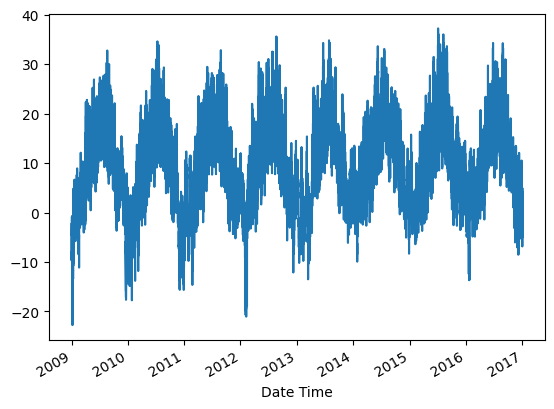

In [42]:
t = df['T (degC)']
t.plot()

In [43]:
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt


def plot_predictions(model,x,y,start=0,end=100):
  predictions = model.predict(x).flatten()
  df=pd.DataFrame(data={'Prediction':predictions, 'Actual':y})
  plt.plot(df['Prediction'][start:end])
  plt.plot(df['Actual'][start:end])
  return df,mse(y, predictions)

# using previous values to predict the next values continuously
# [[[t1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]
#transforms your dataframe into a format suitable for training
# time series forecasting models. It creates features (past data points) and targets (predicted values) based on a sliding window approach
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [44]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(t, WINDOW_SIZE)
X1.shape, y1.shape

((70086, 5, 1), (70086,))

In [45]:
X_train1, y_train1 = X1[:60000], y1[:60000]
X_val1, y_val1 = X1[60000:65000], y1[60000:65000]
X_test1, y_test1 = X1[65000:], y1[65000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((60000, 5, 1), (60000,), (5000, 5, 1), (5000,), (5086, 5, 1), (5086,))

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam


In [47]:

model_conv = Sequential()
model_conv.add(InputLayer((5, 1)))
model_conv.add(Conv1D(64,kernel_size=2))
model_conv.add(Flatten())
model_conv.add(Dense(8, 'relu'))
model_conv.add(Dense(1, 'linear'))

model_conv.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 4, 64)             192       
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 8)                 2056      
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2257 (8.82 KB)
Trainable params: 2257 (8.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
cp1 = ModelCheckpoint('model_conv/', save_best_only=True)
model_conv.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [49]:
# model_conv.fit(X_train1,y_train1, validation_data=(X_val1,y_val1),epochs=10,callbacks=[cp1])

In [50]:
model_lstm = Sequential()
model_lstm.add(InputLayer((5, 1)))
model_lstm.add(LSTM(64))
model_lstm.add(Dense(8, 'relu'))
model_lstm.add(Dense(1, 'linear'))

model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_10 (Dense)            (None, 8)                 520       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
cp2 = ModelCheckpoint('model_lstm/', save_best_only=True)
model_lstm.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [52]:
# model_lstm.fit(X_train1,y_train1, validation_data=(X_val1,y_val1),epochs=10,callbacks=[cp2])

In [53]:
model_gru = Sequential()
model_gru.add(InputLayer((5, 1)))
model_gru.add(GRU(64))
model_gru.add(Dense(8, 'relu'))
model_gru.add(Dense(1, 'linear'))

model_gru.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                12864     
                                                                 
 dense_12 (Dense)            (None, 8)                 520       
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
cp3 = ModelCheckpoint('model_gru/', save_best_only=True)
model_gru.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [55]:
# model_gru.fit(X_train1,y_train1, validation_data=(X_val1,y_val1),epochs=10,callbacks=[cp3])

In [56]:
# now using multiple variables to predict the weather

temp_df=pd.DataFrame({"Temperature": t})
temp_df["Seconds"]= temp_df.index.map(pd.Timestamp.timestamp)         #timestamps in Unix epoch format (seconds since January 1st, 1970) for each row in the index.

In [57]:
day = 60*60*24
year = 365.2425*day
# fills with sinusoidal values based on the timestamps in the "Seconds" column
#  its period is 2π, By multiplying the timestamps in seconds by 2 * np.pi / day,
# scales the seconds within a day to a range suitable for the sine function
temp_df['Day Sine']=np.sin(temp_df['Seconds']*(2*np.pi/day))
temp_df['Day cos']=np.cos(temp_df['Seconds']*(2*np.pi/day))
temp_df['year Sine']=np.sin(temp_df['Seconds']*(2*np.pi/year))
temp_df['year cos']=np.cos(temp_df['Seconds']*(2*np.pi/year))
# drop second bcoz it it captured by the sine and cos values, we dont need an ever increasing value
temp_df.drop("Seconds",axis=1,inplace=True)


In [58]:
def df_to_X_y2(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [59]:
# [[[t1,ds1,dc1,ys1,yc1], [t2,ds2,dc2,ys2,yc2], [t3,ds3,dc3,ys3,yc3], [t4,ds4,dc4,ys4,yc4], [t5,ds5,dc5,ys5,yc5]]]--------->[t6]
X2,y2=df_to_X_y2(temp_df,window_size=6)
X2.shape,y2.shape

((70085, 6, 5), (70085,))

In [60]:
X_train2, y_train2 = X2[:60000], y2[:60000]
X_val2, y_val2 = X2[60000:65000], y2[60000:65000]
X_test2, y_test2 = X2[65000:], y2[65000:]
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((60000, 6, 5), (60000,), (5000, 6, 5), (5000,), (5085, 6, 5), (5085,))

In [61]:
temp_train_mean=np.mean(X_train2[:,:,0])     # just the temperature mean
temp_train_std=np.std(X_train2[:,:,0])        # just the temperature std

def preprocess(X):
  X[:,:,0] = (X[:,:,0]-temp_train_mean/temp_train_std)
  return X

In [ ]:
preprocess(X_train2)
preprocess(X_val2)
preprocess(X_test2)

In [63]:
model_lstm2 = Sequential()
model_lstm2.add(InputLayer((6, 5)))   # 6 timesteps and 5 featues
model_lstm2.add(LSTM(64))
model_lstm2.add(Dense(8, 'relu'))
model_lstm2.add(Dense(1, 'linear'))

model_lstm2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                17920     
                                                                 
 dense_14 (Dense)            (None, 8)                 520       
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18449 (72.07 KB)
Trainable params: 18449 (72.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
cp4= ModelCheckpoint('model_lstm2/', save_best_only=True)
model_lstm2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [65]:
model_lstm2.fit(X_train2,y_train2, validation_data=(X_val2,y_val2),epochs=15,callbacks=[cp4])

Epoch 1/15
1875/1875 [==============================] - 17s 7ms/step - loss: 44.2518 - root_mean_squared_error: 6.6522 - val_loss: 1.3971 - val_root_mean_squared_error: 1.1820
Epoch 2/15
1875/1875 [==============================] - 13s 7ms/step - loss: 2.4288 - root_mean_squared_error: 1.5585 - val_loss: 0.5846 - val_root_mean_squared_error: 0.7646
Epoch 3/15
1875/1875 [==============================] - 14s 7ms/step - loss: 0.8783 - root_mean_squared_error: 0.9372 - val_loss: 0.4628 - val_root_mean_squared_error: 0.6803
Epoch 4/15
1875/1875 [==============================] - 13s 7ms/step - loss: 0.6179 - root_mean_squared_error: 0.7860 - val_loss: 0.4339 - val_root_mean_squared_error: 0.6587
Epoch 5/15
1875/1875 [==============================] - 14s 7ms/step - loss: 0.5542 - root_mean_squared_error: 0.7445 - val_loss: 0.4208 - val_root_mean_squared_error: 0.6487
Epoch 6/15
1875/1875 [==============================] - 13s 7ms/step - loss: 0.5336 - root_mean_squared_error: 0.7305 - val_

159/159 [==============================] - 1s 4ms/step


(      Prediction  Actual
 0      13.226678   13.46
 1      12.877543   12.93
 2      12.457318   12.43
 3      12.118033   12.17
 4      12.230531   11.55
 ...          ...     ...
 5080   -0.767881   -0.98
 5081   -1.317477   -1.40
 5082   -1.695971   -2.75
 5083   -3.070478   -2.89
 5084   -3.171514   -3.93
 
 [5085 rows x 2 columns],
 0.4631518540389263)

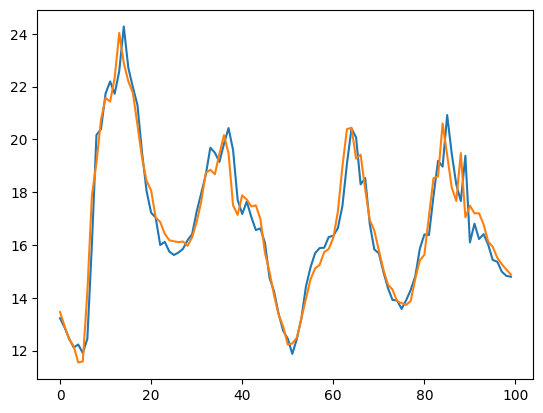

In [66]:
plot_predictions(model_lstm2,X_test2,y_test2)

In [67]:
# now adding pressure

p_temp_df = pd.concat([df['p (mbar)'],temp_df],axis=1)
p_temp_df

,p (mbar),Temperature,Day Sine,Day cos,year Sine,year cos
Date Time,,,,,,
2009-01-01 01:00:00,996.50,-8.05,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,996.62,-8.88,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,996.84,-8.81,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,996.99,-9.05,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,997.46,-9.63,0.965926,0.258819,0.012916,0.999917
...,...,...,...,...,...,...
2016-12-31 19:10:00,1002.18,-0.98,-0.953717,0.300706,0.006900,0.999976
2016-12-31 20:10:00,1001.40,-1.40,-0.843391,0.537300,0.007617,0.999971
2016-12-31 21:10:00,1001.19,-2.75,-0.675590,0.737277,0.008334,0.999965


In [71]:
def df_to_X_y3(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = [df_as_np[i+window_size][0],df_as_np[i+window_size][1]]
    y.append(label)
  return np.array(X), np.array(y)

In [73]:
X3,y3=df_to_X_y3(p_temp_df)
X3.shape,y3.shape

((70084, 7, 6), (70084, 2))

In [74]:
X_train3, y_train3 = X3[:60000], y3[:60000]
X_val3, y_val3 = X3[60000:65000], y3[60000:65000]
X_test3, y_test3 = X3[65000:], y3[65000:]
X_train3.shape, y_train3.shape, X_val3.shape, y_val3.shape, X_test3.shape, y_test3.shape

((60000, 7, 6), (60000, 2), (5000, 7, 6), (5000, 2), (5084, 7, 6), (5084, 2))

In [97]:
temp_train_mean=np.mean(X_train3[:,:,1])     # just the temperature mean
temp_train_std=np.std(X_train3[:,:,1])        # just the temperature std
p_train_mean=np.mean(X_train3[:,:,0])     # just the pressure mean
p_train_std=np.std(X_train3[:,:,0])
def preprocess3(X):
  X[:,:,0] = (X[:,:,0]-p_train_mean)/p_train_std
  X[:,:,1] = (X[:,:,1]-temp_train_mean)/temp_train_std
  return X
def preprocess_output3(y):
  y[:,0] = (y[:,0]-p_train_mean)/p_train_std
  y[:,1] = (y[:,1]-temp_train_mean)/temp_train_std
  return y
preprocess3(X_train3)
preprocess3(X_val3)
preprocess3(X_test3)



array([[[-2.61059418e+00, -2.19342604e+00, -1.20891907e+02,
         -1.19667162e+02, -1.19403104e+02, -1.20778389e+02],
        [ 1.84283690e-01,  5.75619778e-01, -1.97331730e+00,
         -6.07291893e-01, -5.85025130e-01, -1.96007406e+00],
        [ 2.21217224e-01,  5.73451570e-01, -7.07106781e-01,
          7.07106781e-01,  5.21655371e-01, -8.53156301e-01],
        ...,
        [ 2.34798381e-01,  5.36967116e-01, -2.58819045e-01,
          9.65925826e-01,  5.20431780e-01, -8.53903251e-01],
        [ 2.44633013e-01,  5.11240899e-01, -7.16474371e-12,
          1.00000000e+00,  5.19819584e-01, -8.54276068e-01],
        [ 2.50018644e-01,  4.98845540e-01,  2.58819045e-01,
          9.65925826e-01,  5.19207120e-01, -8.54648446e-01]],

       [[-2.59794966e+00, -2.20324878e+00, -1.20792007e+02,
         -1.19425981e+02, -1.19403715e+02, -1.20778764e+02],
        [ 1.95289111e-01,  5.47554814e-01, -1.81439867e+00,
         -4.00185112e-01, -5.85636523e-01, -1.96044819e+00],
        [ 2.28241

In [98]:
preprocess_output3(y_train3)
preprocess_output3(y_val3)
preprocess_output3(y_test3)

array([[3.98291857, 0.50264152],
       [3.98877252, 0.49094778],
       [3.99673389, 0.48486704],
       ...,
       [4.42219877, 0.13592598],
       [4.40955425, 0.13265174],
       [4.39690972, 0.10832877]])

In [99]:
model_lstm3 = Sequential()
model_lstm3.add(InputLayer((7, 6)))   # 7 timesteps and 6 featues
model_lstm3.add(LSTM(64))
model_lstm3.add(Dense(8, 'relu'))
model_lstm3.add(Dense(2, 'linear'))

model_lstm3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 64)                18176     
                                                                 
 dense_22 (Dense)            (None, 8)                 520       
                                                                 
 dense_23 (Dense)            (None, 2)                 18        
                                                                 
Total params: 18714 (73.10 KB)
Trainable params: 18714 (73.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [100]:
cp5= ModelCheckpoint('model_lstm3/', save_best_only=True)
model_lstm3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [101]:
model_lstm3.fit(X_train3,y_train3, validation_data=(X_val3,y_val3),epochs=15,callbacks=[cp5])

Epoch 1/15
1875/1875 [==============================] - 19s 9ms/step - loss: 1.4581 - root_mean_squared_error: 1.2075 - val_loss: 0.2641 - val_root_mean_squared_error: 0.5139
Epoch 2/15
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1241 - root_mean_squared_error: 0.3523 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1192
Epoch 3/15
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0184 - root_mean_squared_error: 0.1357 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0790
Epoch 4/15
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0048 - root_mean_squared_error: 0.0695 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390
Epoch 5/15
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0018 - root_mean_squared_error: 0.0427 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
Epoch 6/15
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_l

In [102]:

def plot_predictions2(model,X,y,start=0,end=100):
  pred=model.predict(X)
  p_pred,t_pred=pred[:,0],pred[:,1]
  p_actual,t_actual=y[:,0],y[:,1]
  df = pd.DataFrame(data={'predicted_temp':t_pred,
                          'actual_temp':t_actual,
                          'predicted_pressure':p_pred,
                          'actual_pressure':p_actual})
  plt.plot(df['predicted_temp'][start:end])
  plt.plot(df['actual_temp'][start:end])
  plt.plot(df['predicted_pressure'][start:end])
  plt.plot(df['actual_pressure'][start:end])
  return df[start:end]

159/159 [==============================] - 1s 3ms/step


,predicted_temp,actual_temp,predicted_pressure,actual_pressure
0,0.485911,0.502642,3.975049,3.982919
1,0.475239,0.490948,3.976891,3.988773
2,0.469424,0.484867,3.982809,3.996734
3,0.472293,0.470367,3.992289,4.010081
4,0.478046,0.471302,4.009666,4.010081
...,...,...,...,...
95,0.535665,0.563215,4.049439,4.055742
96,0.528788,0.557368,4.048370,4.059020
97,0.524700,0.552691,4.048803,4.059020
98,0.525896,0.548247,4.050266,4.058786


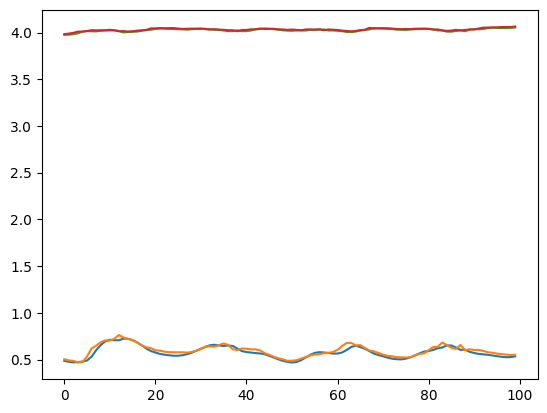

In [103]:
plot_predictions2(model_lstm3,X_test3,y_test3)

In [104]:
def postprocess_temp(arr):
  arr=(arr*temp_train_std)+temp_train_mean
  return arr
def postprocess_p(arr):
  arr=(arr*p_train_std)+p_train_mean
  return arr


In [105]:

def plot_predictions2(model,X,y,start=0,end=100):
  pred=model.predict(X)
  p_pred,t_pred=postprocess_p(pred[:,0]),postprocess_temp(pred[:,1])
  p_actual,t_actual=postprocess_p(y[:,0]),postprocess_temp(y[:,1])
  df = pd.DataFrame(data={'predicted_temp':t_pred,
                          'actual_temp':t_actual,
                          'predicted_pressure':p_pred,
                          'actual_pressure':p_actual})
  plt.plot(df['predicted_temp'][start:end])
  plt.plot(df['actual_temp'][start:end])
  plt.plot(df['predicted_pressure'][start:end])
  plt.plot(df['actual_pressure'][start:end])
  return df[start:end]

159/159 [==============================] - 1s 5ms/step


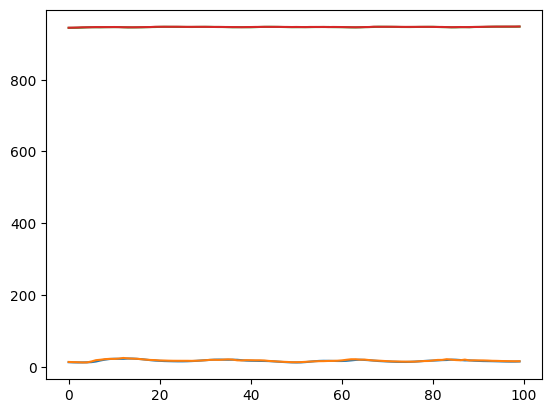

In [107]:
postprocessed_df=plot_predictions2(model_lstm3,X_test3,y_test3)

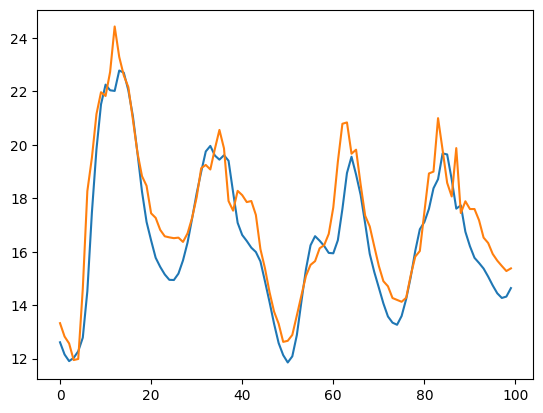

In [108]:
start=0
end=100
plt.plot(postprocessed_df['predicted_temp'][start:end])
plt.plot(postprocessed_df['actual_temp'][start:end])


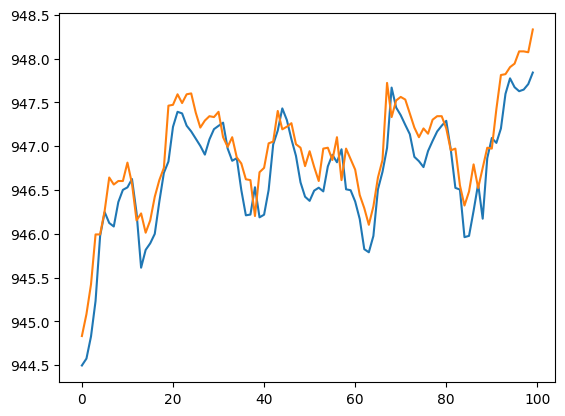

In [110]:
plt.plot(postprocessed_df['predicted_pressure'][start:end])
plt.plot(postprocessed_df['actual_pressure'][start:end])

In [111]:
model_lstm4 = Sequential()
model_lstm4.add(InputLayer((7, 6)))   # 7 timesteps and 6 featues
model_lstm4.add(LSTM(32,return_sequences=True))
model_lstm4.add(LSTM(64))
model_lstm4.add(Dense(8, 'relu'))
model_lstm4.add(Dense(2, 'linear'))

model_lstm4.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 7, 32)             4992      
                                                                 
 lstm_9 (LSTM)               (None, 64)                24832     
                                                                 
 dense_24 (Dense)            (None, 8)                 520       
                                                                 
 dense_25 (Dense)            (None, 2)                 18        
                                                                 
Total params: 30362 (118.60 KB)
Trainable params: 30362 (118.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [112]:
cp6= ModelCheckpoint('model_lstm4/', save_best_only=True)
model_lstm4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [113]:
model_lstm4.fit(X_train3,y_train3, validation_data=(X_val3,y_val3),epochs=15,callbacks=[cp6])

Epoch 1/15
1875/1875 [==============================] - 30s 13ms/step - loss: 0.4269 - root_mean_squared_error: 0.6534 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1310
Epoch 2/15
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0042 - root_mean_squared_error: 0.0647 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0429
Epoch 3/15
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0016 - root_mean_squared_error: 0.0404 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0391
Epoch 4/15
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0015 - root_mean_squared_error: 0.0385 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0380
Epoch 5/15
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0014 - root_mean_squared_error: 0.0371 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0372
Epoch 6/15
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0013 - root_mean_squared_error: 0.0358 -

159/159 [==============================] - 2s 4ms/step


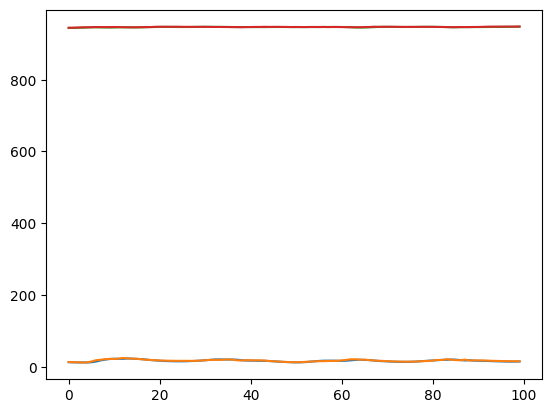

In [115]:
postprocessed_df=plot_predictions2(model_lstm4,X_test3,y_test3)

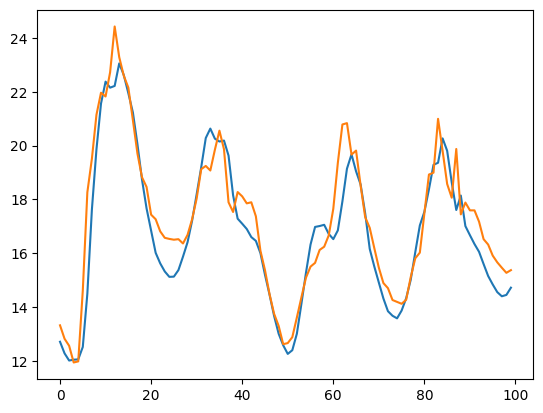

In [116]:
plt.plot(postprocessed_df['predicted_temp'][start:end])
plt.plot(postprocessed_df['actual_temp'][start:end])

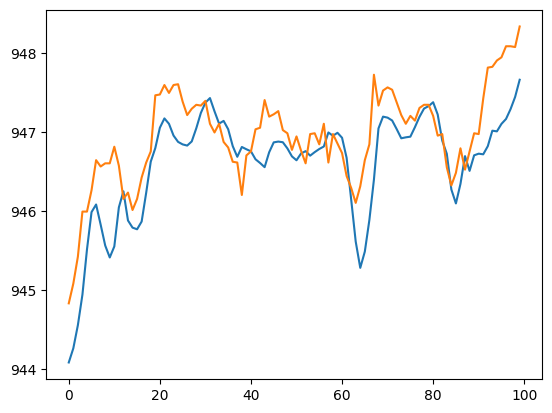

In [117]:
plt.plot(postprocessed_df['predicted_pressure'][start:end])
plt.plot(postprocessed_df['actual_pressure'][start:end])

In [118]:
postprocessed_df

,predicted_temp,actual_temp,predicted_pressure,actual_pressure
0,12.715216,13.3258,944.084961,944.832493
1,12.283722,12.8258,944.264282,945.082493
2,12.017927,12.5658,944.556824,945.422493
3,12.049591,11.9458,944.942566,945.992493
4,12.059454,11.9858,945.514465,945.992493
...,...,...,...,...
95,14.844618,15.9158,947.101013,947.942493
96,14.559629,15.6658,947.163147,948.082493
97,14.404858,15.4658,947.288025,948.082493
98,14.454454,15.2758,947.441895,948.072493
